In [61]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

from astropy.table import Table
import astropy.units as u
import astropy.coordinates as coord
from astropy.io import ascii

from pyia import GaiaData
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.dynamics import mockstream


In [62]:
plt.style.use('si_lgray_ucondensed')

## Stream members

In [29]:
def gd1_dist(phi1):
    # 0, 10
    # -60, 7
    m = (10-7) / (60)
    return (m*phi1.wrap_at(180*u.deg).value + 10) * u.kpc

wangle = 180*u.deg

In [30]:
gd1_c = c.transform_to(gc.GD1)

gd1_c_dist = gc.GD1(phi1=gd1_c.phi1, phi2=gd1_c.phi2,
                    distance=gd1_dist(gd1_c.phi1),
                    pm_phi1_cosphi2=gd1_c.pm_phi1_cosphi2,
                    pm_phi2=gd1_c.pm_phi2,
                    radial_velocity=[0]*len(gd1_c)*u.km/u.s)

# Correct for reflex motion
v_sun = coord.Galactocentric.galcen_v_sun
observed = gd1_c_dist.transform_to(coord.Galactic)
rep = observed.cartesian.without_differentials()
rep = rep.with_differentials(observed.cartesian.differentials['s'] + v_sun)
gd1_c = coord.Galactic(rep).transform_to(gc.GD1)

In [97]:
g_ = GaiaData('../data/gd1-with-masks.fits')
stream = g_[g_.pm_mask & g_.gi_cmd_mask]

In [98]:
pmem = np.load('../output/pmem.npy')

(-90, 0)

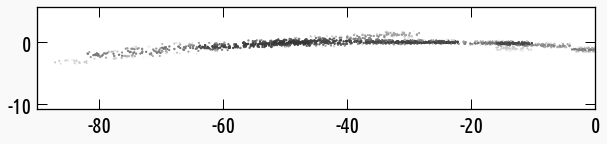

In [113]:
plt.figure(figsize=(10,10))
plt.scatter(stream.phi1, stream.phi2, s=pmem*2, c=pmem, cmap=mpl.cm.binary, vmin=0.5, vmax=1.1)
plt.gca().set_aspect('equal')
plt.xlim(-90,0)


In [326]:
c = gc.GD1(phi1=stream.phi1, phi2=stream.phi2, distance=poly(coord.Angle(stream.phi1).wrap_at(wangle))*u.kpc-0.1*u.kpc)
cgal = c.transform_to(coord.Galactocentric)

In [327]:
R = np.sqrt(cgal.y**2 + cgal.x**2)

## Stream model

In [116]:
ham = gp.Hamiltonian(gp.MilkyWayPotential(nucleus=dict(m=0), 
                                          halo=dict(c=0.95, m=7E11),
                                          bulge=dict(m=4E9),
                                          disk=dict(m=5.5e10)))
gc_frame = coord.Galactocentric(galcen_distance=8*u.kpc, z_sun=0*u.pc)


In [117]:
pos = np.load('../data/gd1_orbit.npy')

In [118]:
pos

array([  10.        ,   -2.11070977,   10.88423961,   -7.27543097,
         -1.64769694, -297.92249248])

In [333]:
prog_phi0 = -13.5*u.deg
prog_phi0 = -20*u.deg

model_gd1 = fit_orbit.to_coord_frame(gc.GD1, galactocentric_frame=gc_frame)
prog_i = np.abs(model_gd1.phi1.wrap_at(180*u.deg) - prog_phi0).argmin()
prog_w0 = fit_orbit[prog_i][0]
print(prog_w0)

pos=(-11.74403847, 1.74597434, 7.19387437) kpc
vel=(-0.11220275, -0.24382675, -0.10482119) kpc / Myr


In [334]:
prog_orbit = ham.integrate_orbit(prog_w0, 
                                 dt=-0.5, t1=0*u.Myr, t2=-4*u.Gyr)
prog_orbit = prog_orbit[::-1]

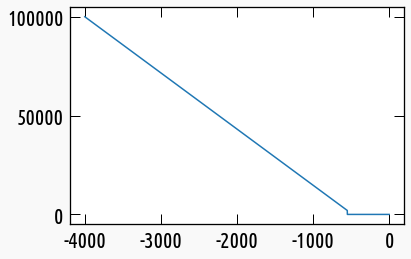

In [335]:
# stream = mockstream.fardal_stream(ham, prog_orbit, 4E5*u.Msun, release_every=1)

t_disrupt = -550*u.Myr
# t_disrupt = -50 *u.Myr
n_times = (prog_orbit.t < t_disrupt).sum()
prog_mass = np.linspace(1E5, 2E3, n_times)
prog_mass = np.concatenate((prog_mass, np.zeros(len(prog_orbit.t) - n_times))) * u.Msun
plt.plot(prog_orbit.t, prog_mass)
model = mockstream.dissolved_fardal_stream(ham, prog_orbit, prog_mass=prog_mass, 
                                            t_disrupt=t_disrupt, release_every=1)

n_steps_disrupt = int(abs(t_disrupt / (prog_orbit.t[1]-prog_orbit.t[0])))
model = model[:-2*n_steps_disrupt]

## Orbit

In [336]:
phi1, phi2, d, pm1, pm2, vr = pos

c = gc.GD1(phi1=phi1*u.deg, phi2=phi2*u.deg, distance=d*u.kpc, 
           pm_phi1_cosphi2=pm1*u.mas/u.yr,
           pm_phi2=pm2*u.mas/u.yr,
           radial_velocity=vr*u.km/u.s)
w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)

orbit_rr_long = ham.integrate_orbit(w0, dt=-0.5, t1=0*u.Myr, t2=-5000*u.Myr)
orbit_rr = ham.integrate_orbit(w0, dt=-0.5, t1=0*u.Myr, t2=-70*u.Myr)
orbit_fwd = ham.integrate_orbit(w0, dt=0.5, t1=0*u.Myr, t2=70*u.Myr)
orbits = ham.integrate_orbit(w0, dt=0.5, t1=-100*u.Myr, t2=100*u.Myr)

In [337]:
dt = 0.5 * u.Myr
n_steps = 250

_phi2_sigma = 0.2 # deg
_dist_sigma = 0.1 # kpc
_vr_sigma = 1 # km/s

In [338]:
fit_orbit = ham.integrate_orbit(w0, dt=dt, n_steps=120)

In [339]:
np.min(orbit_rr_long.spherical.distance), np.max(orbit_rr_long.spherical.distance)

(<Distance 13.5082942 kpc>, <Distance 23.07168719 kpc>)

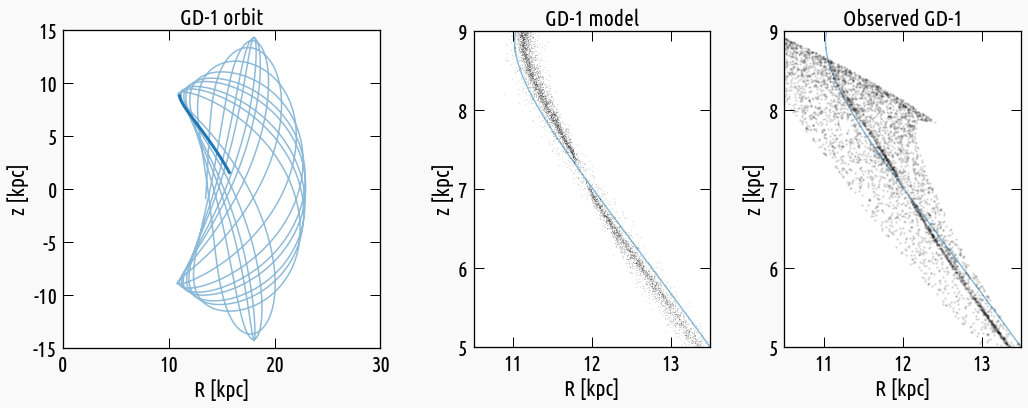

In [340]:
fig, ax = plt.subplots(1,3, figsize=(15,6), gridspec_kw = {'width_ratios':[1.5,1,1]})

plt.sca(ax[0])
for orbit in [orbit_rr_long,]:
    plt.plot(orbit.cylindrical.rho, orbit.cylindrical.z, '-', color='tab:blue', alpha=0.5)

plt.plot(fit_orbit.cylindrical.rho.value, fit_orbit.cylindrical.z.value, '-', color='tab:blue', lw=3)

plt.title('GD-1 orbit', fontsize='medium')
plt.xlabel('R [kpc]')
plt.ylabel('z [kpc]')
plt.xlim(0,30)
plt.ylim(-15,15)
plt.gca().set_aspect('equal')

plt.sca(ax[1])
for orbit in [orbit_rr, orbit_fwd]:
    plt.plot(orbit.cylindrical.rho, orbit.cylindrical.z, '-', color='tab:blue', alpha=0.5)
plt.plot(model.cylindrical.rho, model.z, 'k.', alpha=0.5, ms=0.2)

plt.title('GD-1 model', fontsize='medium')
plt.xlabel('R [kpc]')
plt.ylabel('z [kpc]')
plt.xlim(10.5,13.5)
plt.ylim(5,9)
plt.gca().set_aspect('equal')

plt.sca(ax[2])
for orbit in [orbit_rr, orbit_fwd]:
    plt.plot(orbit.cylindrical.rho, orbit.cylindrical.z, '-', color='tab:blue', alpha=0.5)
mem = pmem>0.4
plt.plot(R, cgal.z, 'k.', alpha=0.1, ms=3)

plt.title('Observed GD-1', fontsize='medium')
plt.xlabel('R [kpc]')
plt.ylabel('z [kpc]')
plt.xlim(10.5,13.5)
plt.ylim(5,9)
plt.gca().set_aspect('equal')

plt.tight_layout()
plt.savefig('../plots/nl/cylindrical_orbit.png', dpi=150)

In [263]:
model_gd1 = model.to_coord_frame(gc.GD1, galactocentric_frame=gc_frame)

In [264]:
orbit_x = np.concatenate([orbit_rr.x.to(u.kpc).value, orbit_fwd.x.to(u.kpc).value])*u.kpc
orbit_y = np.concatenate([orbit_rr.y.to(u.kpc).value, orbit_fwd.y.to(u.kpc).value])*u.kpc
orbit_z = np.concatenate([orbit_rr.z.to(u.kpc).value, orbit_fwd.z.to(u.kpc).value])*u.kpc

In [272]:
orbit_x = np.concatenate([orbit_fwd.x.to(u.kpc).value])*u.kpc
orbit_y = np.concatenate([orbit_fwd.y.to(u.kpc).value])*u.kpc
orbit_z = np.concatenate([orbit_fwd.z.to(u.kpc).value])*u.kpc

In [273]:
c_orbit = coord.Galactocentric(x=orbit_x, y=orbit_y, z=orbit_z)
gd1_orbit = c_orbit.transform_to(gc.GD1)

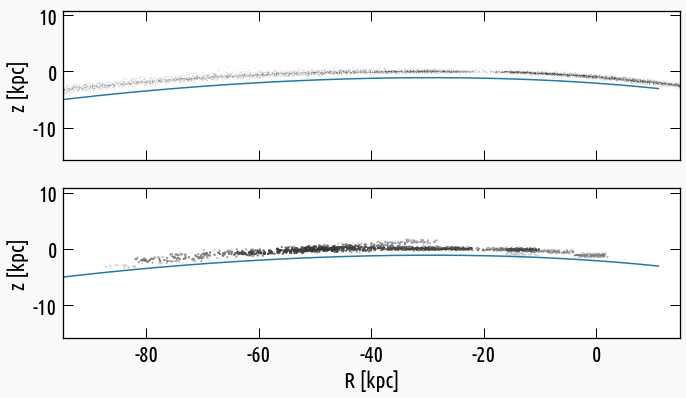

In [274]:
fig, ax = plt.subplots(2,1,figsize=(10,6), sharex=True, sharey=True)

plt.sca(ax[0])
# for orbit in [orbit_rr, orbit_fwd]:
#     plt.plot(orbit.cylindrical.rho, orbit.cylindrical.z, '-', color='tab:blue', alpha=0.5)
plt.plot(model_gd1.phi1.wrap_at(wangle), model_gd1.phi2, 'k.', alpha=0.2, ms=0.3)
# plt.plot(fit_orbit.cylindrical.rho.value, fit_orbit.cylindrical.z.value, '-', color='tab:blue', lw=1)
plt.plot(gd1_orbit.phi1.wrap_at(wangle), gd1_orbit.phi2, '-')

# plt.title('GD-1 model', fontsize='medium')
# plt.xlabel('R [kpc]')
plt.ylabel('z [kpc]')
# plt.xlim(10,17)
# plt.ylim(0,10)
plt.gca().set_aspect('equal')

plt.sca(ax[1])
# for orbit in [orbit_rr, orbit_fwd]:
#     plt.plot(orbit.cylindrical.rho, orbit.cylindrical.z, '-', color='tab:blue', alpha=0.5)
plt.scatter(stream.phi1, stream.phi2, s=pmem*2, c=pmem, cmap=mpl.cm.binary, vmin=0.5, vmax=1.1)
plt.plot(gd1_orbit.phi1.wrap_at(wangle), gd1_orbit.phi2, '-')
plt.gca().set_aspect('equal')
plt.xlim(-90,10)
plt.ylim(-10,5)


# plt.title('Observed GD-1', fontsize='medium')
plt.xlabel('R [kpc]')
plt.ylabel('z [kpc]')
# plt.xlim(10,17)
# plt.ylim(0,10)
plt.gca().set_aspect('equal')
plt.tight_layout()


In [276]:
p = np.polyfit(gd1_orbit.phi1.wrap_at(wangle), gd1_orbit.distance, 3)

In [278]:
poly = np.poly1d(p)

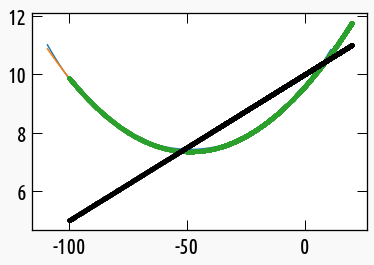

In [281]:
plt.plot(gd1_orbit.phi1.wrap_at(wangle), gd1_orbit.distance, '-')
plt.plot(gd1_orbit.phi1.wrap_at(wangle), poly(gd1_orbit.phi1.wrap_at(wangle)), '-')
plt.plot(stream.phi1, poly(stream.phi1), '.')
plt.plot(stream.phi1, gd1_dist(coord.Angle(stream.phi1)), 'k.')